In [0]:
# Read the CSV file with corrected file path
df = spark.read.csv("/FileStore/tables/Employee_Compensation.csv", header=True, inferSchema=True)

# Show the DataFrame
df.show()


+---------+----+-----------------------+--------------------+---------------+--------------------+----------+--------------------+---------------+--------------------+--------+--------------------+-------------------+---------+--------+--------------+------------+----------+-------------+--------------+--------------+------------------+
|Year Type|Year|Organization Group Code|  Organization Group|Department Code|          Department|Union Code|               Union|Job Family Code|          Job Family|Job Code|                 Job|Employee Identifier| Salaries|Overtime|Other Salaries|Total Salary|Retirement|Health/Dental|Other Benefits|Total Benefits|Total Compensation|
+---------+----+-----------------------+--------------------+---------------+--------------------+----------+--------------------+---------------+--------------------+--------+--------------------+-------------------+---------+--------+--------------+------------+----------+-------------+--------------+--------------+---

In [0]:
# Display the number of rows
num_rows = df.count()
print("Number of rows:", num_rows)

# Display the number of columns
num_columns = len(df.columns)
print("Number of columns:", num_columns)


Number of rows: 291825
Number of columns: 22


In [0]:
# Display the schema to check data types
df.printSchema()


root
 |-- Year Type: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Organization Group Code: integer (nullable = true)
 |-- Organization Group: string (nullable = true)
 |-- Department Code: string (nullable = true)
 |-- Department: string (nullable = true)
 |-- Union Code: integer (nullable = true)
 |-- Union: string (nullable = true)
 |-- Job Family Code: string (nullable = true)
 |-- Job Family: string (nullable = true)
 |-- Job Code: string (nullable = true)
 |-- Job: string (nullable = true)
 |-- Employee Identifier: integer (nullable = true)
 |-- Salaries: double (nullable = true)
 |-- Overtime: double (nullable = true)
 |-- Other Salaries: double (nullable = true)
 |-- Total Salary: double (nullable = true)
 |-- Retirement: double (nullable = true)
 |-- Health/Dental: double (nullable = true)
 |-- Other Benefits: double (nullable = true)
 |-- Total Benefits: double (nullable = true)
 |-- Total Compensation: double (nullable = true)



In [0]:
from pyspark.sql.functions import col

# Convert incorrect column types
df = df.withColumn("Salaries", df["Salaries"].cast("double"))
df = df.withColumn("Overtime", df["Overtime"].cast("double"))
df = df.withColumn("Other Salaries", df["Other Salaries"].cast("double"))
df = df.withColumn("Total Salary", df["Total Salary"].cast("double"))
df = df.withColumn("Retirement", df["Retirement"].cast("double"))
df = df.withColumn("Health/Dental", df["Health/Dental"].cast("double"))
df = df.withColumn("Other Benefits", df["Other Benefits"].cast("double"))
df = df.withColumn("Total Benefits", df["Total Benefits"].cast("double"))
df = df.withColumn("Total Compensation", df["Total Compensation"].cast("double"))

# Drop redundant features
redundant_features = ["Year Type", "Organization Group Code", "Department Code", "Union Code", "Job Family Code", "Job Code", "Employee Identifier"]
df = df.drop(*redundant_features)

# Display the schema after changes
df.printSchema()


root
 |-- Year: integer (nullable = true)
 |-- Organization Group: string (nullable = true)
 |-- Department: string (nullable = true)
 |-- Union: string (nullable = true)
 |-- Job Family: string (nullable = true)
 |-- Job: string (nullable = true)
 |-- Salaries: double (nullable = true)
 |-- Overtime: double (nullable = true)
 |-- Other Salaries: double (nullable = true)
 |-- Total Salary: double (nullable = true)
 |-- Retirement: double (nullable = true)
 |-- Health/Dental: double (nullable = true)
 |-- Other Benefits: double (nullable = true)
 |-- Total Benefits: double (nullable = true)
 |-- Total Compensation: double (nullable = true)



In [0]:
from pyspark.sql import functions as F

# Check basic statistics
df.describe().show()

# Remove negative amounts
df = df.filter((F.col("Salaries") >= 0) & 
               (F.col("Overtime") >= 0) & 
               (F.col("Other Salaries") >= 0) & 
               (F.col("Total Salary") >= 0) & 
               (F.col("Retirement") >= 0) & 
               (F.col("Health/Dental") >= 0) & 
               (F.col("Other Benefits") >= 0) & 
               (F.col("Total Benefits") >= 0) & 
               (F.col("Total Compensation") >= 0))

# Display the schema after changes
df.printSchema()


+-------+------------------+--------------------+-------------------+--------------------+--------------------+------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+-----------------+------------------+------------------+
|summary|              Year|  Organization Group|         Department|               Union|          Job Family|               Job|          Salaries|          Overtime|   Other Salaries|      Total Salary|        Retirement|    Health/Dental|   Other Benefits|    Total Benefits|Total Compensation|
+-------+------------------+--------------------+-------------------+--------------------+--------------------+------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+-----------------+------------------+------------------+
|  count|            290391|              290391|             290391|              290348|             

In [0]:
from pyspark.sql import functions as F

# Count the number of null values in each column
missing_values = df.agg(*[
    (F.count(F.when(F.col(c).isNull(), c)) / F.count(c)).alias(c + '_missing')
    for c in df.columns
])

# Show missing value analysis result
missing_values.show()


+------------+--------------------------+------------------+--------------------+--------------------+-----------+----------------+----------------+----------------------+--------------------+------------------+---------------------+----------------------+----------------------+--------------------------+
|Year_missing|Organization Group_missing|Department_missing|       Union_missing|  Job Family_missing|Job_missing|Salaries_missing|Overtime_missing|Other Salaries_missing|Total Salary_missing|Retirement_missing|Health/Dental_missing|Other Benefits_missing|Total Benefits_missing|Total Compensation_missing|
+------------+--------------------------+------------------+--------------------+--------------------+-----------+----------------+----------------+----------------------+--------------------+------------------+---------------------+----------------------+----------------------+--------------------------+
|         0.0|                       0.0|               0.0|1.480981442958105..

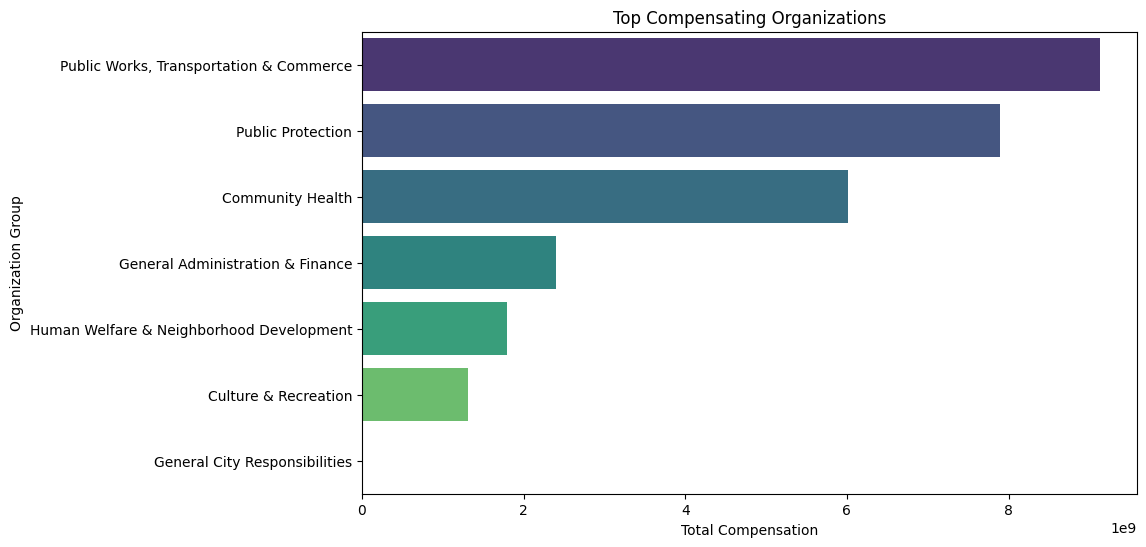

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F

# Aggregate total compensation by organization
total_compensation_by_org = df.groupBy("Organization Group").agg(F.sum("Total Compensation").alias("Total Compensation"))

# Sort the data by total compensation in descending order
total_compensation_by_org = total_compensation_by_org.orderBy(F.desc("Total Compensation"))

# Convert PySpark DataFrame to Pandas DataFrame for plotting
total_compensation_by_org_pd = total_compensation_by_org.toPandas()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x="Total Compensation", y="Organization Group", data=total_compensation_by_org_pd, palette="viridis")
plt.xlabel("Total Compensation")
plt.ylabel("Organization Group")
plt.title("Top Compensating Organizations")
plt.show()


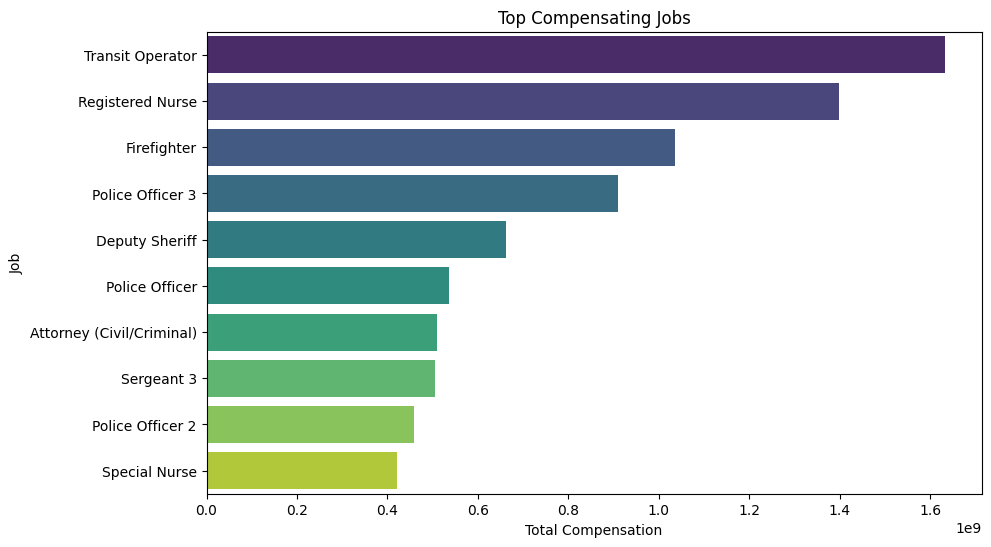

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F

# Aggregate total compensation by job
total_compensation_by_job = df.groupBy("Job").agg(F.sum("Total Compensation").alias("Total Compensation"))

# Sort the data by total compensation in descending order
total_compensation_by_job = total_compensation_by_job.orderBy(F.desc("Total Compensation"))

# Limit to top N jobs if needed
# total_compensation_by_job = total_compensation_by_job.limit(N)

# Convert PySpark DataFrame to Pandas DataFrame for plotting
total_compensation_by_job_pd = total_compensation_by_job.toPandas()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x="Total Compensation", y="Job", data=total_compensation_by_job_pd.head(10), palette="viridis")
plt.xlabel("Total Compensation")
plt.ylabel("Job")
plt.title("Top Compensating Jobs")
plt.show()


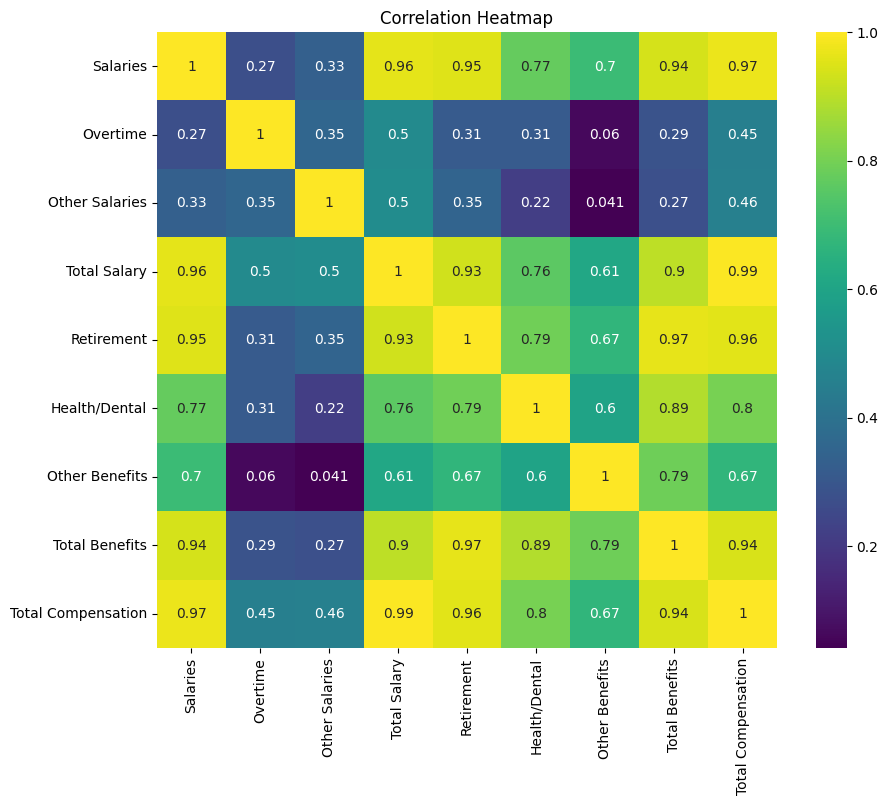

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler

# Create a SparkSession
spark = SparkSession.builder \
    .appName("Correlation Analysis") \
    .getOrCreate()

# Assuming 'df' is your DataFrame with relevant columns

# Selecting relevant columns for correlation analysis
selected_columns = ["Salaries", "Overtime", "Other Salaries", "Total Salary", 
                    "Retirement", "Health/Dental", "Other Benefits", "Total Benefits", 
                    "Total Compensation"]

# Selecting only the selected columns
df_selected = df.select(selected_columns)

# Drop rows with missing values
df_selected = df_selected.dropna()

# Convert DataFrame to Pandas for easier correlation analysis
df_pandas = df_selected.toPandas()

# Calculate the correlation matrix
correlation_matrix = df_pandas.corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="viridis")
plt.title("Correlation Heatmap")
plt.show()


In [0]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

# Assuming 'df' is your DataFrame

# Define numerical and categorical columns
numerical_cols = ["Salaries", "Overtime", "Other Salaries", "Total Salary", 
                  "Retirement", "Health/Dental", "Other Benefits", "Total Benefits", 
                  "Total Compensation"]

categorical_cols = ["Organization Group", "Department", "Union", "Job Family", "Job"]

# Index categorical columns
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index", handleInvalid="keep") 
            for col in categorical_cols]

# One-hot encode categorical columns
encoders = [OneHotEncoder(inputCol=col+"_index", outputCol=col+"_encoded") 
            for col in categorical_cols]

# Assemble features
assembler_inputs = [col + "_encoded" for col in categorical_cols] + numerical_cols
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

# Apply transformations
pipeline_stages = indexers + encoders + [assembler]
pipeline = Pipeline(stages=pipeline_stages)
transformed_df = pipeline.fit(df).transform(df)

# Show the transformed DataFrame
transformed_df.show()


+----+--------------------+--------------------+--------------------+--------------------+--------------------+---------+--------+--------------+------------+----------+-------------+--------------+--------------+------------------+------------------------+----------------+-----------+----------------+---------+--------------------------+------------------+---------------+------------------+------------------+--------------------+
|Year|  Organization Group|          Department|               Union|          Job Family|                 Job| Salaries|Overtime|Other Salaries|Total Salary|Retirement|Health/Dental|Other Benefits|Total Benefits|Total Compensation|Organization Group_index|Department_index|Union_index|Job Family_index|Job_index|Organization Group_encoded|Department_encoded|  Union_encoded|Job Family_encoded|       Job_encoded|            features|
+----+--------------------+--------------------+--------------------+--------------------+--------------------+---------+--------+

In [0]:
# Split the data into train and test sets
train_ratio = 0.8
test_ratio = 1 - train_ratio
seed = 42  # for reproducibility

train_data, test_data = transformed_df.randomSplit([train_ratio, test_ratio], seed=seed)

# Show the count of rows in each set
print("Train set count:", train_data.count())
print("Test set count:", test_data.count())


Train set count: 232592
Test set count: 57799


In [0]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Define the Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="Total Compensation")

# Fit the model on the training data
lr_model = lr.fit(train_data)

# Make predictions on the test data
predictions = lr_model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="Total Compensation", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

print("Root Mean Squared Error (RMSE) on test data:", rmse)

# Print the coefficients and intercept of the model
print("Coefficients:", lr_model.coefficients)
print("Intercept:", lr_model.intercept)


Root Mean Squared Error (RMSE) on test data: 5.539394120734976
Coefficients: [2.668978716834479,4.628507925076288,-12.428829536000361,2.2181851717097927,2.0170430434304216,2.543787583036069,-1.1226047452701975,4.628507925076288,0.5447915506617398,2.0271205274852964,20.127241418086683,1.399087199255943,2.0084861244613474,-89.0014033109965,3.3662109091411967,38.818513274182386,-0.9951129408720422,1.5121578292868982,4.415196817707683,0.6129627528678564,10.269336217548735,-109.74356470242313,3.3188266075877633,19.254929094425524,3.711176357204711,5.974556025494201,17.377807737595315,18.703337343878385,7.568667914363736,4.402665656998326,6.677869011652039,2.677335891651302,-2.357618032668837,5.5419483450609945,0.6719699351668476,7.277639223904511,3.9090461680714794,16.762242933653553,22.10318145584267,7.177736134008772,5.210844650593307,2.7421032265748324,1.7915314527059916,2.853055344326898,0.7085301128870917,5.8700944285769,-31.933834073204935,-1.5969733702887108,1.9591584790815704,1.9996